In [1]:
import numpy as np
from scipy.integrate import quad
import emcee
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm

### Data and Parameters

In [2]:
# Redshift (z)
z_data = np.array([0.9, 1.2, 1.5])

# Angular diameter distances and errors [Mpc]
dA_data = np.array([1688, 1781, 1793])
dA_err  = np.array([47, 46, 28])

# Hubble parameter and errors [km/s/Mpc]
H_data = np.array([112.1, 136.9, 154.7])
H_err  = np.array([3.8,   5.7,   6.0])

In [3]:
c = 299792.458          # speed of light [km/s]
H0 = 67                 # Hubble constant [km/s/Mpc]
Omega_m = 0.319         # Omega matter
Omega_de = 1 - Omega_m  # Omega dark energy

## flat-LambdaCDM

In [4]:


# Hubble Parameter
def hubble_lambdaCDM(z, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de):
    H=H0*np.sqrt(Omega_m *(1+z)**3 + Omega_de)
    return H

# Angular diameter distance
def angular_diameter_distance_lambdaCDM(z_array, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de, c=c):
    def integrand(zp, H0, Omega_m, Omega_de):
        return c / hubble_lambdaCDM(zp, H0, Omega_m, Omega_de)

    results = []
    for z in np.atleast_1d(z_array):
        integral, _ = quad(integrand, 0, z, args=(H0, Omega_m, Omega_de))
        dA = integral / (1 + z)
        results.append(dA)

    return np.array(results)

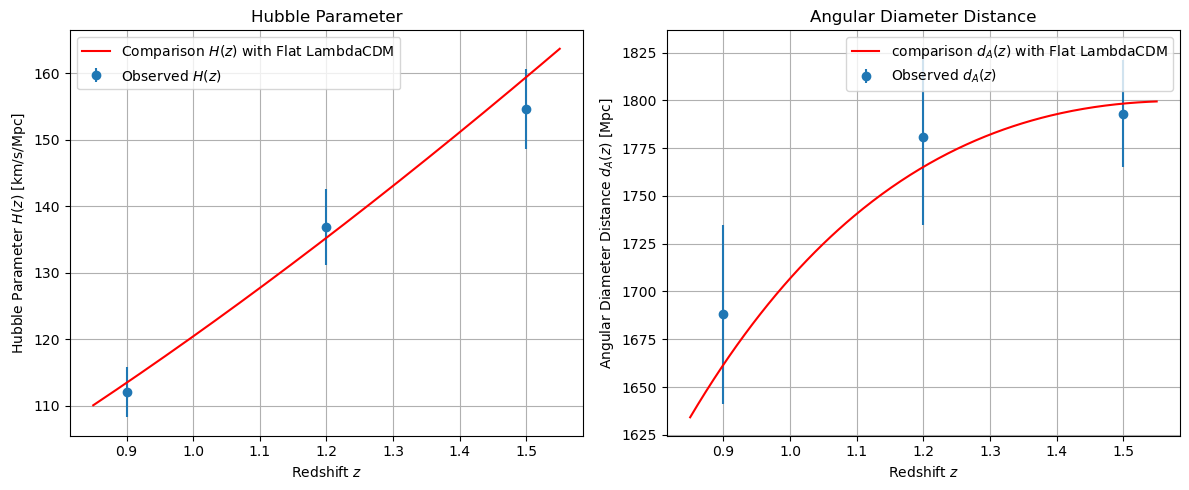

In [5]:
# Best-fit parameters


z = np.linspace(min(z_data) - 0.05, max(z_data) + 0.05, 300)

# Evaluate model on dense grid
H = hubble_lambdaCDM(z)
dA= angular_diameter_distance_lambdaCDM(z)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H(z)
ax1.errorbar(z_data, H_data, yerr=H_err, fmt='o', label="Observed $H(z)$")
ax1.plot(z, H, '-', color='red', label="Comparison $H(z)$ with Flat LambdaCDM")
ax1.set_xlabel("Redshift $z$")
ax1.set_ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
ax1.set_title("Hubble Parameter")
ax1.legend()
ax1.grid(True)

# d_A(z)
ax2.errorbar(z_data, dA_data, yerr=dA_err, fmt='o', label="Observed $d_A(z)$")
ax2.plot(z, dA, '-', color='red', label="comparison $d_A(z)$ with Flat LambdaCDM")
ax2.set_xlabel("Redshift $z$")
ax2.set_ylabel("Angular Diameter Distance $d_A(z)$ [Mpc]")
ax2.set_title("Angular Diameter Distance")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [6]:
chi2_H = np.sum(((H_data - hubble_lambdaCDM(z_data)) / H_err) ** 2)
chi2_dA = np.sum(((dA_data - angular_diameter_distance_lambdaCDM(z_data)) / dA_err) ** 2)
print(f"Chi-squared for Hubble Parameter: {chi2_H:.2f}")
print(f"Chi-squared for Angular Diameter Distance: {chi2_dA:.2f}")

#now they are separate, later these two funciton will be summed, that's why it will be bigger

Chi-squared for Hubble Parameter: 0.85
Chi-squared for Angular Diameter Distance: 0.47


## Markov Chain Monte Carlo

### Omega-matter fixed

Functions to calculate H and $d_A$

In [7]:
def get_Omega_de(Omega_m_1):
    return 1 - Omega_m_1


# Hubble Parameter
def hubble(z, w0, wa, H0, Omega_m, Omega_de):
    term1 = Omega_m * (1 + z)**3
    exponent = 3 * (1 + w0 + wa)
    term2 = Omega_de * (1 + z)**exponent * np.exp(-3 * wa * z / (1 + z))
    return H0 * np.sqrt(term1 + term2)

# Angular diameter distance
def angular_diameter_distance(z_array, w0, wa, H0, Omega_m, Omega_de, c):
    def integrand(zp, w0, wa, H0, Omega_m, Omega_de):
        return c / hubble(zp, w0, wa, H0, Omega_m, Omega_de)

    results = []
    for z in np.atleast_1d(z_array):
        integral, _ = quad(integrand, 0, z, args=(w0, wa, H0, Omega_m, Omega_de))
        dA = integral / (1 + z)
        results.append(dA)

    return np.array(results)

# Get functions that only take as arguments the parameters we actually want to optimize over
hubble_fit_func = lambda z, w0, wa: hubble(z=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de)
dA_fit_func     = lambda z, w0, wa: angular_diameter_distance(z_array=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m, Omega_de=Omega_de, c=c)

Define functions needed for MCMC

In [8]:
def log_likelihood(theta):
    w0, wa = theta
    H_model = hubble_fit_func(z_data, w0, wa)
    dA_model = dA_fit_func(z_data, w0, wa)

    chi2_H = np.sum(((H_data - H_model) / H_err) ** 2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err) ** 2)

    return -0.5 * (chi2_H + chi2_dA)

# Define prior (uniform distribution within search area)
def log_prior(theta):
    w0, wa = theta
    if -5 < w0 < 1 and -6 < wa < 5: # search area
        return 0.0  # flat prior = constant log prior
    return -np.inf  # log(0), SET TO 0 FOR UNBOUNDED SEARCH

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

Run MCMC

In [9]:
# Params
ndim = 2
nwalkers = 128
nsteps = 2000#500

# Initial guess
p0 = np.array([-1.0, 0.0])
initial_positions = p0 + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

100%|██████████| 2000/2000 [00:21<00:00, 94.22it/s]


State([[-0.8553589  -1.05051142]
 [-0.58809948 -1.95450677]
 [-0.55335083 -2.76405809]
 [-1.10578738  0.41331058]
 [-1.18958413  0.58491381]
 [-1.18993564  0.50960276]
 [ 0.07386916 -5.07482725]
 [-1.39060813  1.90518164]
 [-0.88232736 -1.01074824]
 [-0.63321587 -1.87026136]
 [-0.3642118  -3.29931271]
 [-1.00297602 -0.02365613]
 [-0.76264126 -1.42013187]
 [-1.17494459  0.59356653]
 [-0.31058407 -3.67087011]
 [-0.77076946 -1.64513123]
 [-0.92930158 -0.92068153]
 [-0.91537619 -0.88281638]
 [-0.3361536  -3.1268944 ]
 [-1.16999883  0.77160233]
 [-0.91956081 -0.23605286]
 [-0.62763019 -1.63850265]
 [-1.19189225  0.71593156]
 [-0.67546918 -1.24928541]
 [-0.02955247 -5.1476875 ]
 [-0.34737562 -2.9555731 ]
 [-0.30314862 -3.77163311]
 [-0.72573444 -1.61472312]
 [ 0.04544263 -5.35779488]
 [-1.30750245  0.90247142]
 [-1.51131189  2.23357539]
 [-0.96562263 -0.27506053]
 [-0.6182894  -1.80004485]
 [-0.56992585 -1.98504097]
 [-0.91384013 -0.5641393 ]
 [-0.87100491 -0.72470905]
 [-0.97535819 -0.16989

Get results and plot them. Use median $\pm$ credible interval (most common in astro/cosmo)

w0 = -0.904 (+0.316/-0.280)
wa = -0.578 (+1.218/-1.506)


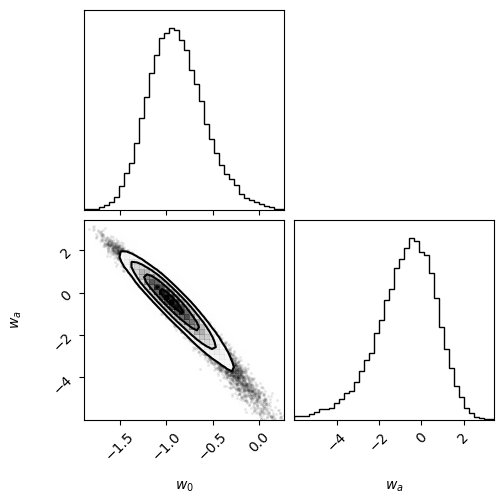

In [10]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)

w0_16, w0_50, w0_84 = np.percentile(samples[:, 0], [16, 50, 84])
wa_16, wa_50, wa_84 = np.percentile(samples[:, 1], [16, 50, 84])

print(f"w0 = {w0_50:.3f} (+{w0_84 - w0_50:.3f}/-{w0_50 - w0_16:.3f})")
print(f"wa = {wa_50:.3f} (+{wa_84 - wa_50:.3f}/-{wa_50 - wa_16:.3f})")

# fig = corner.corner(samples, labels=[r"$w_0$", r"$w_a$"], truths=[None, None])
fig = corner.corner(
    samples,
    labels=[r"$w_0$", r"$w_a$"],
    bins=40,         # increase from default 30
    smooth=1.0,       # apply KDE smoothing
    #smooth1d=1.0      # smooth the 1D marginals too
)
plt.show()

Get stats and chi-square

In [11]:
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# MEDIAN POSTERIOR
w0_med, wa_med = np.median(samples, axis=0)

H_model_med = hubble_fit_func(z_data, w0_med, wa_med)
dA_model_med = dA_fit_func(z_data, w0_med, wa_med)

chi2_H_med = np.sum(((H_data - H_model_med) / H_err)**2)
chi2_dA_med = np.sum(((dA_data - dA_model_med) / dA_err)**2)
chi2_total_med = chi2_H_med + chi2_dA_med

# MOST PROBABLE SET OF PARAMETERS
log_probs = np.array([log_posterior(p) for p in samples])
best_index = np.argmax(log_probs)
w0_map, wa_map = samples[best_index]

H_model_map = hubble_fit_func(z_data, w0_map, wa_map)
dA_model_map = dA_fit_func(z_data, w0_map, wa_map)
chi2_map = np.sum(((H_data - H_model_map) / H_err)**2) + np.sum(((dA_data - dA_model_map) / dA_err)**2)

# MIN CHI-SQUARE SAMPLE (find sample with lowest chi-square)
def chi2_total(params):
    w0, wa = params
    H_model = hubble_fit_func(z_data, w0, wa)
    dA_model = dA_fit_func(z_data, w0, wa)
    chi2_H = np.sum(((H_data - H_model) / H_err)**2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err)**2)
    return chi2_H + chi2_dA

chi2s = np.array([chi2_total(p) for p in samples])
min_index = np.argmin(chi2s)
w0_best_chi2, wa_best_chi2 = samples[min_index]
chi2_min = chi2s[min_index]

# Center of posterior distribution
print("Median Posterior:")
print(f"  w0 = {w0_med:.3f}, wa = {wa_med:.3f}, chi² = {chi2_total_med:.2f}")

# Most probable set of parameters
print("\nMAP (max posterior):")
print(f"  w0 = {w0_map:.3f}, wa = {wa_map:.3f}, chi² = {chi2_map:.2f}")

print("\nMin Chi² Sample:")
print(f"  w0 = {w0_best_chi2:.3f}, wa = {wa_best_chi2:.3f}, chi² = {chi2_min:.2f}")

Median Posterior:
  w0 = -0.904, wa = -0.578, chi² = 1.15

MAP (max posterior):
  w0 = -0.976, wa = -0.224, chi² = 1.06

Min Chi² Sample:
  w0 = -0.976, wa = -0.224, chi² = 1.06


Plot the best fit line (uses MAP)

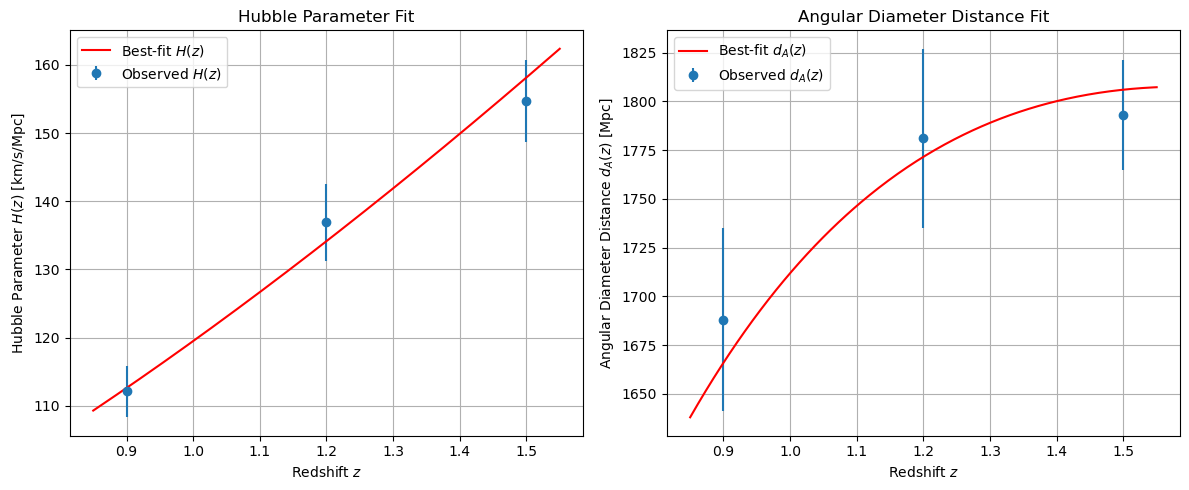

In [12]:
# Best-fit parameters
w0_best, wa_best = w0_map, wa_map #np.median(samples, axis=0)

# Dense redshift sampling for smooth curves
z_dense = np.linspace(min(z_data) - 0.05, max(z_data) + 0.05, 300)

# Evaluate model on dense grid
H_model_dense = hubble_fit_func(z_dense, w0_best, wa_best)
dA_model_dense = dA_fit_func(z_dense, w0_best, wa_best)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H(z)
ax1.errorbar(z_data, H_data, yerr=H_err, fmt='o', label="Observed $H(z)$")
ax1.plot(z_dense, H_model_dense, '-', color='red', label="Best-fit $H(z)$")
ax1.set_xlabel("Redshift $z$")
ax1.set_ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
ax1.set_title("Hubble Parameter Fit")
ax1.legend()
ax1.grid(True)

# d_A(z)
ax2.errorbar(z_data, dA_data, yerr=dA_err, fmt='o', label="Observed $d_A(z)$")
ax2.plot(z_dense, dA_model_dense, '-', color='red', label="Best-fit $d_A(z)$")
ax2.set_xlabel("Redshift $z$")
ax2.set_ylabel("Angular Diameter Distance $d_A(z)$ [Mpc]")
ax2.set_title("Angular Diameter Distance Fit")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Comparison of LAMDA-CDM with best fit

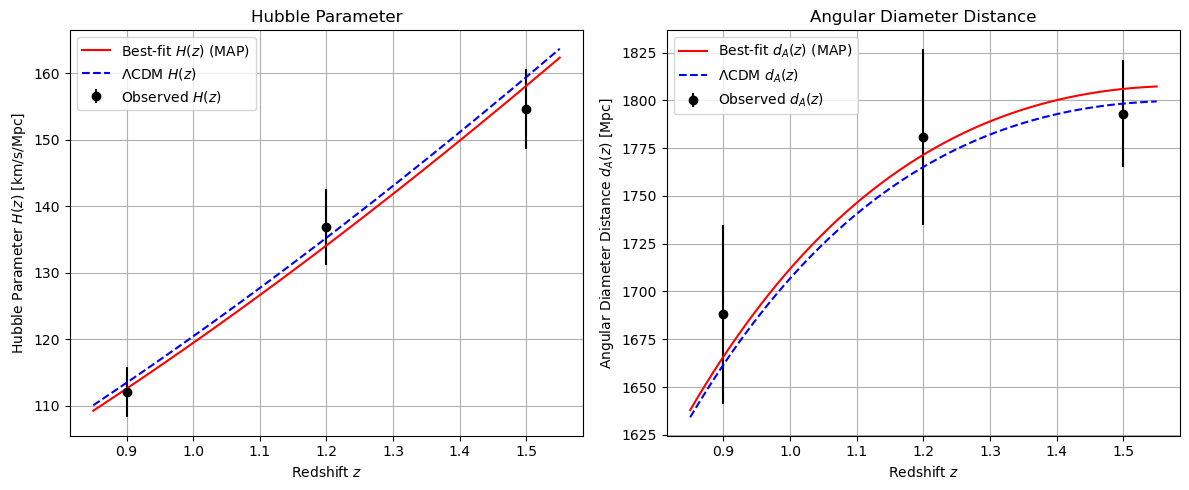

In [13]:
# Best-fit parameters
w0_best, wa_best = w0_map, wa_map

# Dense redshift sampling for smooth curves
z_dense = np.linspace(min(z_data) - 0.05, max(z_data) + 0.05, 300)

# Evaluate models on dense grid
H_model_bestfit = hubble_fit_func(z_dense, w0_best, wa_best)
dA_model_bestfit = dA_fit_func(z_dense, w0_best, wa_best)

# ΛCDM curves
H_lcdm = hubble_lambdaCDM(z_dense)
dA_lcdm = angular_diameter_distance_lambdaCDM(z_dense)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Hubble Parameter ---
ax1.errorbar(z_data, H_data, yerr=H_err, fmt='o', label="Observed $H(z)$", color='black')
ax1.plot(z_dense, H_model_bestfit, '-', color='red', label="Best-fit $H(z)$ (MAP)")
ax1.plot(z_dense, H_lcdm, '--', color='blue', label="ΛCDM $H(z)$")
ax1.set_xlabel("Redshift $z$")
ax1.set_ylabel("Hubble Parameter $H(z)$ [km/s/Mpc]")
ax1.set_title("Hubble Parameter")
ax1.legend()
ax1.grid(True)

# --- Angular Diameter Distance ---
ax2.errorbar(z_data, dA_data, yerr=dA_err, fmt='o', label="Observed $d_A(z)$", color='black')
ax2.plot(z_dense, dA_model_bestfit, '-', color='red', label="Best-fit $d_A(z)$ (MAP)")
ax2.plot(z_dense, dA_lcdm, '--', color='blue', label="ΛCDM $d_A(z)$")
ax2.set_xlabel("Redshift $z$")
ax2.set_ylabel("Angular Diameter Distance $d_A(z)$ [Mpc]")
ax2.set_title("Angular Diameter Distance")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Omega-matter variable

In [14]:
hubble_fit_func_4 = lambda z, w0, wa, Omega_m_1, Omega_de_1: hubble(z=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m_1, Omega_de=Omega_de_1)
dA_fit_func_4     = lambda z, w0, wa, Omega_m_1, Omega_de_1: angular_diameter_distance(z_array=z, w0=w0, wa=wa, H0=H0, Omega_m=Omega_m_1, Omega_de=Omega_de_1, c=c)

In [15]:
def log_likelihood_4(theta):
    w0, wa, Omega_m_1 = theta
    H_model = hubble_fit_func_4(z_data, w0, wa, Omega_m_1, get_Omega_de(Omega_m_1))
    dA_model = dA_fit_func_4(z_data, w0, wa, Omega_m_1, get_Omega_de(Omega_m_1))

    chi2_H = np.sum(((H_data - H_model) / H_err) ** 2)
    chi2_dA = np.sum(((dA_data - dA_model) / dA_err) ** 2)

    return -0.5 * (chi2_H + chi2_dA)

# Define prior (uniform distribution within search area)
def log_prior_4(theta):
    w0, wa, Omega_m_1 = theta
    if -5 < w0 < 4 and -30 < wa < 5 and 0.0< Omega_m_1 < 1.1: # search area
    # if -10 < w0 < 10 and -50 < wa < 50 and -5< Omega_m_1 < 5:
        return 0.0  # flat prior = constant log prior
    return -np.inf  # log(0), SET TO 0 FOR UNBOUNDED SEARCH

def log_posterior_4(theta):
    lp = log_prior_4(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_4(theta)

In [16]:
# Params
ndim = 3
nwalkers = 128#32
nsteps = 1000

# Initial guess
p0 = np.array([-1.0, 0.0, 0.7])
initial_positions = p0 + 1e-2 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_4)
sampler.run_mcmc(initial_positions, nsteps, progress=True)

100%|██████████| 1000/1000 [00:15<00:00, 63.24it/s]


State([[-6.08856514e-01 -4.16424568e+00  3.67894010e-01]
 [-7.11184242e-01 -3.26211490e+00  3.70966001e-01]
 [-1.94788761e+00 -9.02243034e-01  4.20400621e-01]
 [-8.44716288e-01 -5.13446204e+00  4.11766314e-01]
 [-1.15377675e+00  4.37834682e-01  3.29372674e-01]
 [-1.10100581e+00  7.71731071e-01  2.75048073e-01]
 [ 3.46668983e-01 -7.79794642e+00  3.47363666e-01]
 [ 1.55784271e+00 -1.91780235e+01  3.95760236e-01]
 [ 1.84524073e+00 -2.40274703e+01  3.86892446e-01]
 [-6.39480095e-01 -1.81035050e+00  3.23172568e-01]
 [-9.44395823e-01 -2.35509348e+00  3.58907577e-01]
 [-1.27925826e+00 -1.24719258e+00  3.80870871e-01]
 [ 6.43631934e-01 -1.28990487e+01  3.90765764e-01]
 [-1.22237164e+00  1.50161709e+00  2.83046881e-01]
 [-2.92915681e-01 -5.85875434e+00  3.85039625e-01]
 [-4.45524108e-02 -7.81045946e+00  3.68179469e-01]
 [ 1.07367069e+00 -1.59541813e+01  3.80474315e-01]
 [ 1.49857762e-01 -8.95297480e+00  3.74710608e-01]
 [-6.08875870e-01 -3.58376957e+00  3.88474404e-01]
 [ 8.52014582e-01 -1.5864

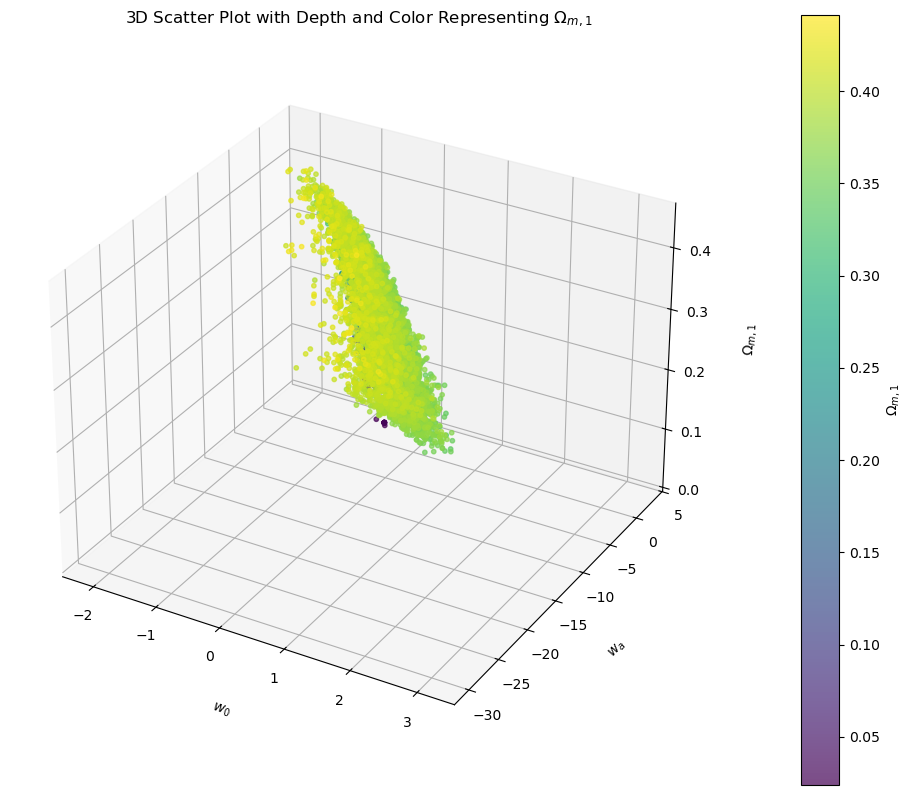

In [17]:
# Extract the samples
samples = sampler.get_chain(discard=400, thin=10, flat=True)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the samples with color representing Omega_m_1
sc = ax.scatter(
    samples[:, 0], samples[:, 1], samples[:, 2],
    c=samples[:, 2], cmap='viridis', s=10, alpha=0.7, depthshade=True
)

# Add a colorbar to indicate the scale of Omega_m_1
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label(r"$\Omega_{m,1}$")

# Label the axes
ax.set_xlabel(r"$w_0$", labelpad=15)
ax.set_ylabel(r"$w_a$", labelpad=15)
ax.set_zlabel(r"$\Omega_{m,1}$", labelpad=15)

# Add a title
ax.set_title("3D Scatter Plot with Depth and Color Representing $\Omega_{m,1}$", pad=20)

# Show the plot
plt.show()

In [18]:
# Compute percentiles for w0, wa, and Omega_m_1
w0_16, w0_50, w0_84 = np.percentile(samples[:, 0], [16, 50, 84])
wa_16, wa_50, wa_84 = np.percentile(samples[:, 1], [16, 50, 84])
Omega_m_1_16, Omega_m_1_50, Omega_m_1_84 = np.percentile(samples[:, 2], [16, 50, 84])

# Print results
print(f"w0 = {w0_50:.3f} (+{w0_84 - w0_50:.3f}/-{w0_50 - w0_16:.3f})")
print(f"wa = {wa_50:.3f} (+{wa_84 - wa_50:.3f}/-{wa_50 - wa_16:.3f})")
print(f"Omega_m_1 = {Omega_m_1_50:.3f} (+{Omega_m_1_84 - Omega_m_1_50:.3f}/-{Omega_m_1_50 - Omega_m_1_16:.3f})")


# Find MAP (maximum a posteriori) estimate
# Evaluate the log posterior for all samples

log_posteriors = np.array([log_posterior_4(p) for p in samples])
map_index = np.argmax(log_posteriors)
w0_map, wa_map, Omega_m_1_map = samples[map_index]

print(f"\nMAP estimates:")
print(f"w0 = {w0_map:.3f}")
print(f"wa = {wa_map:.3f}")
print(f"Omega_m_1 = {Omega_m_1_map:.3f}")

w0 = 0.045 (+1.790/-0.998)
wa = -8.933 (+8.833/-15.079)
Omega_m_1 = 0.373 (+0.022/-0.054)

MAP estimates:
w0 = -0.876
wa = 0.946
Omega_m_1 = 0.166


Plot omega_m with color gradient

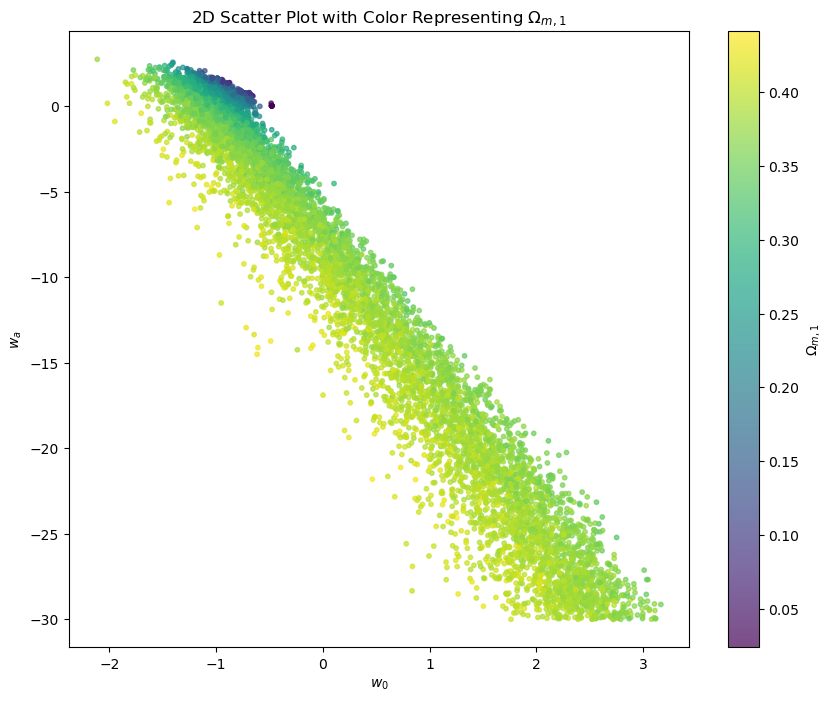

In [19]:
# Create a 2D scatter plot with color representing Omega_m_1
plt.figure(figsize=(10, 8))
sc = plt.scatter(samples[:, 0], samples[:, 1], c=samples[:, 2], cmap='viridis', s=10, alpha=0.7)

# Add a colorbar to show the scale of Omega_m_1
cbar = plt.colorbar(sc)
cbar.set_label(r"$\Omega_{m,1}$")

# Label the axes
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_a$")
plt.title("2D Scatter Plot with Color Representing $\Omega_{m,1}$")

# Show the plot
plt.show()

Plot slices of omega

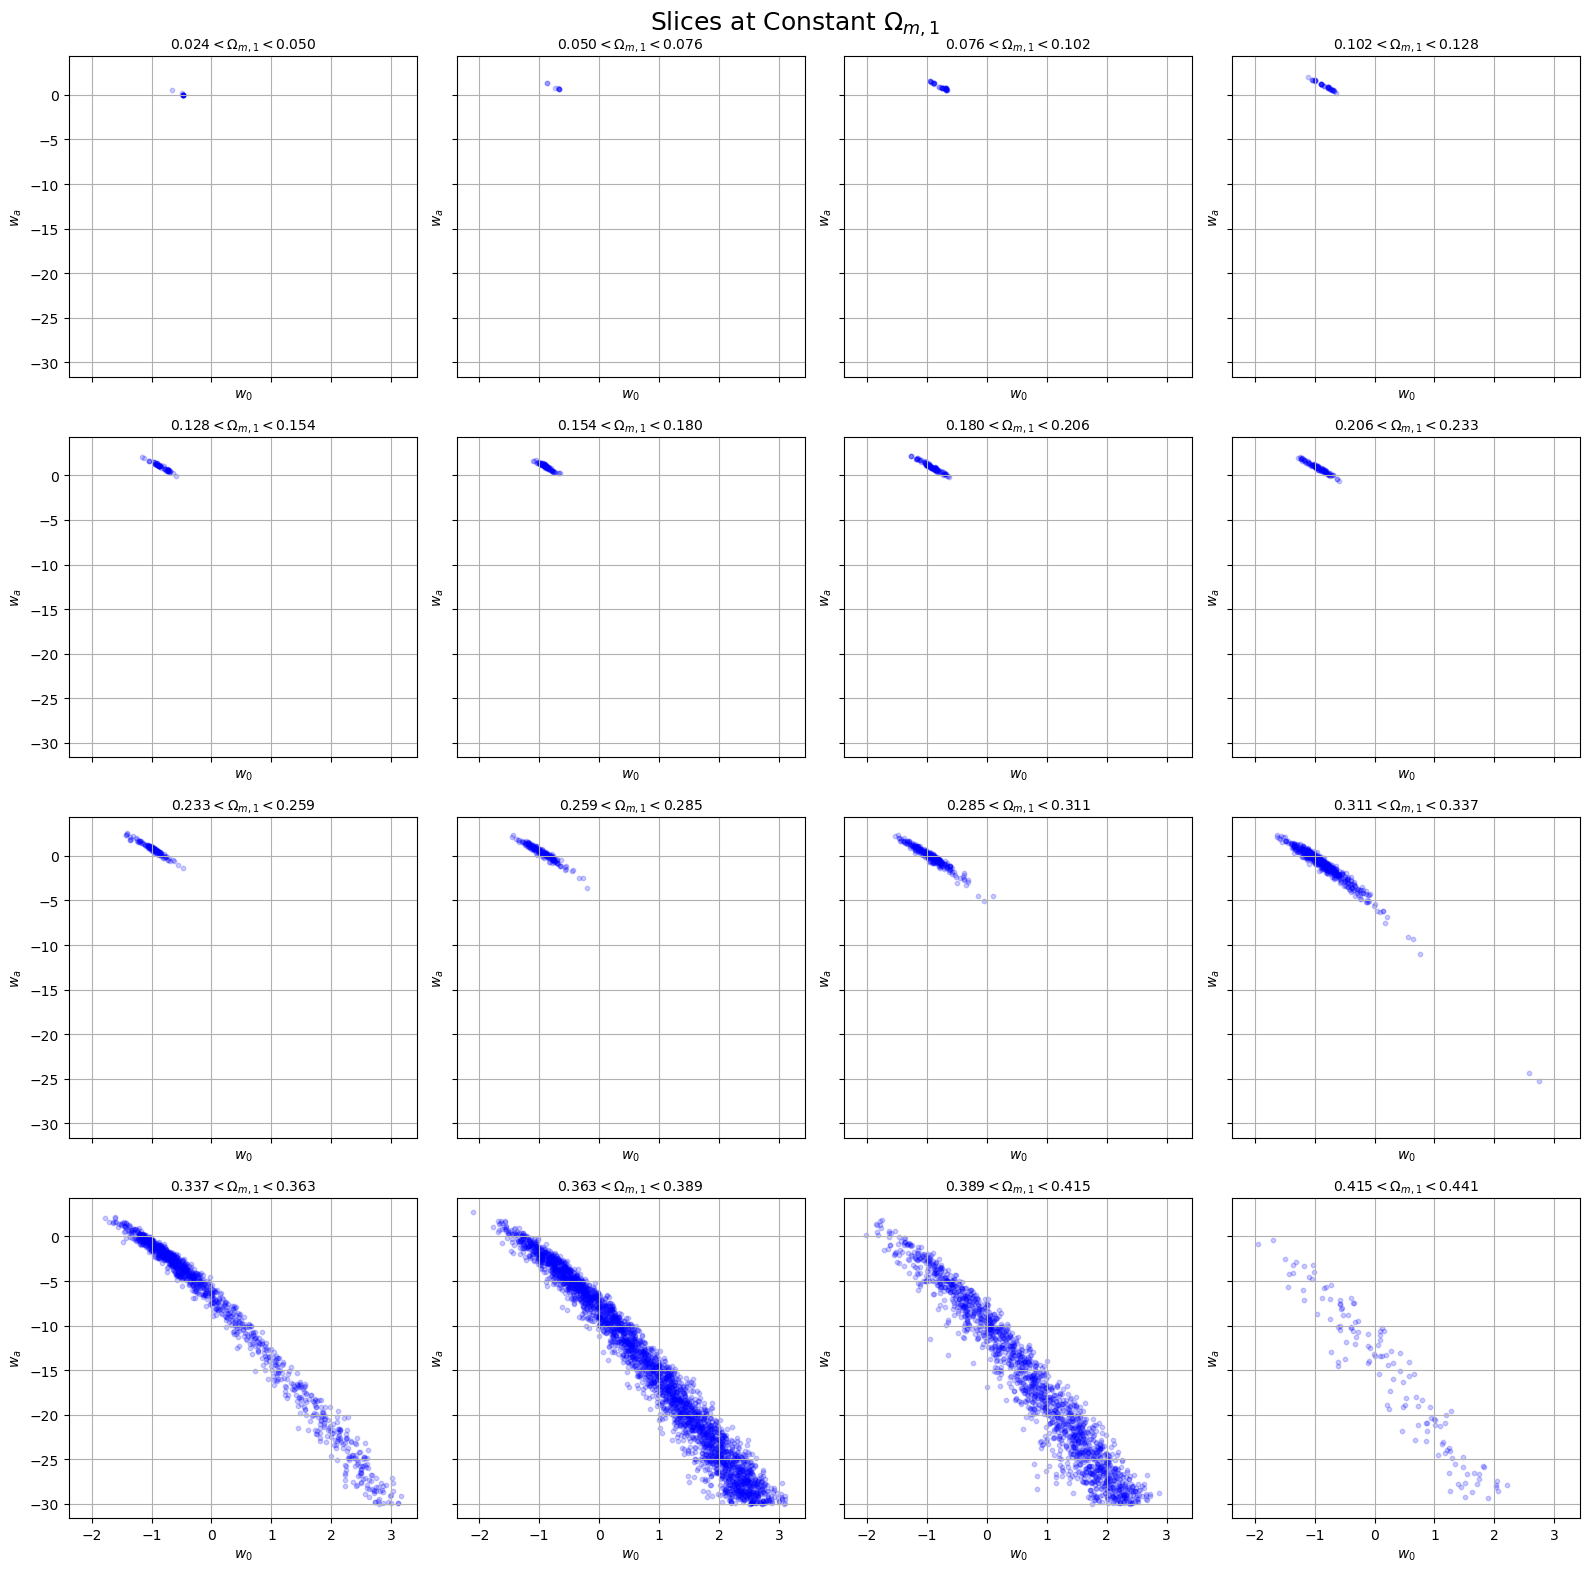

In [20]:
# Slices settings
Omega_m1_min = samples[:, 2].min()
Omega_m1_max = samples[:, 2].max()

nslices = 16  # number of slices
slice_edges = np.linspace(Omega_m1_min, Omega_m1_max, nslices + 1)

# Compute approximate rows and columns
ncols = int(np.ceil(np.sqrt(nslices)))
nrows = int(np.ceil(nslices / ncols))

# Create subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=True, sharey=True)
axes = axes.flatten()  # flatten in case it's 2D array of axes

for i in range(nslices):
    ax = axes[i]
    lower, upper = slice_edges[i], slice_edges[i+1]
    
    # Select samples within this slice
    mask = (samples[:, 2] >= lower) & (samples[:, 2] < upper)
    slice_samples = samples[mask]
    
    # Scatter plot
    ax.scatter(slice_samples[:, 0], slice_samples[:, 1], s=10, alpha=0.2, color='blue')
    ax.set_title(f"${lower:.3f} < \\Omega_{{m,1}} < {upper:.3f}$", fontsize=10)
    
    ax.set_xlabel(r"$w_0$", fontsize=10)
    ax.set_ylabel(r"$w_a$", fontsize=10)
    ax.grid(True)

# Hide unused subplots (if any)
for j in range(nslices, nrows * ncols):
    fig.delaxes(axes[j])

fig.suptitle("Slices at Constant $\Omega_{m,1}$", fontsize=18)
plt.tight_layout()
plt.show()

Ger marginal distributions

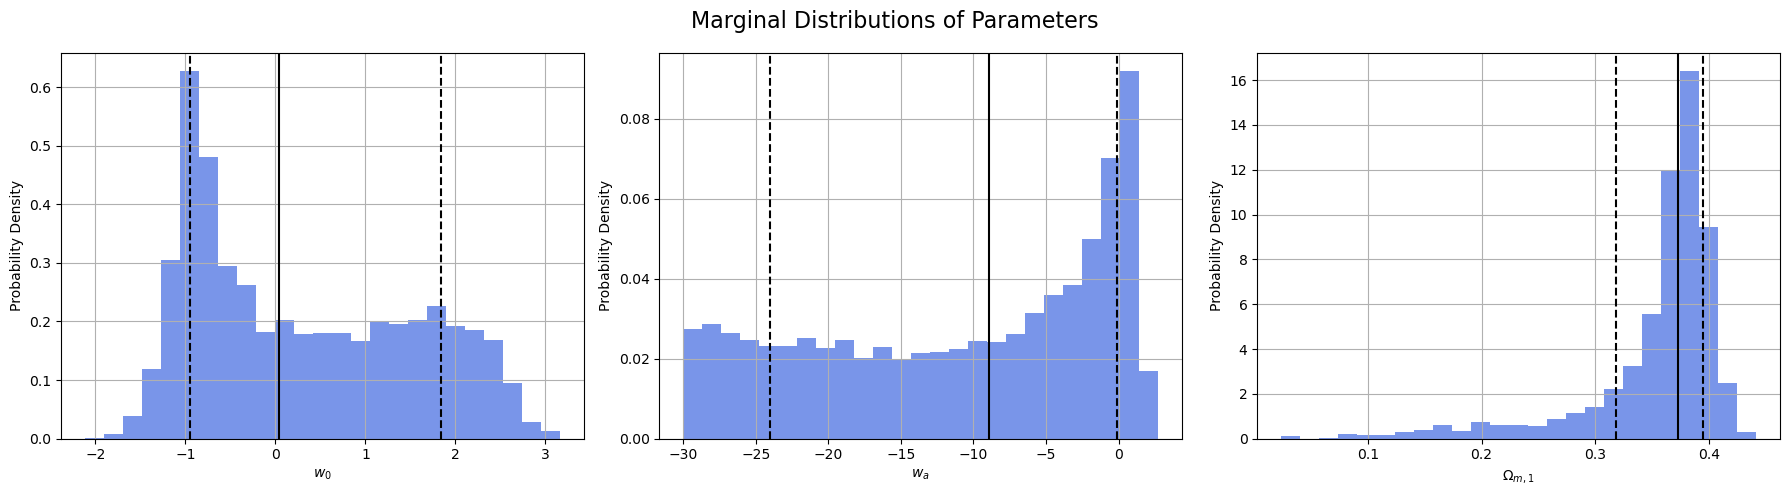

In [21]:
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

param_names = [r"$w_0$", r"$w_a$", r"$\Omega_{m,1}$"]

for i in range(3):
    ax = axes[i]
    
    ax.hist(samples[:, i], bins=25, density=True, color="royalblue", alpha=0.7)
    
    # Add vertical lines at 16th, 50th, and 84th percentiles
    p16, p50, p84 = np.percentile(samples[:, i], [16, 50, 84])
    ax.axvline(p16, color="black", linestyle="--")
    ax.axvline(p50, color="black", linestyle="-")
    ax.axvline(p84, color="black", linestyle="--")
    
    ax.set_xlabel(param_names[i])
    ax.set_ylabel("Probability Density")
    ax.grid(True)

fig.suptitle("Marginal Distributions of Parameters", fontsize=16)
plt.tight_layout()
plt.show()

Check convergence

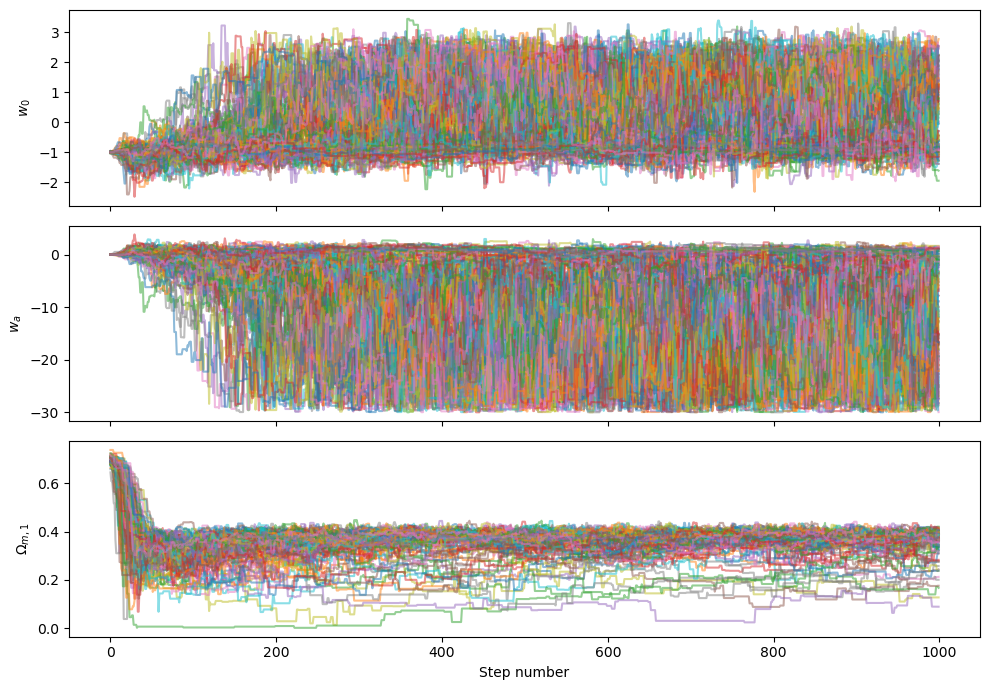

In [22]:
samples_chain = sampler.get_chain()

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

for i in range(nwalkers):
    axes[0].plot(samples_chain[:, i, 0], alpha=0.5)
    axes[1].plot(samples_chain[:, i, 1], alpha=0.5)
    axes[2].plot(samples_chain[:, i, 2], alpha=0.5)

axes[0].set_ylabel(r"$w_0$")
axes[1].set_ylabel(r"$w_a$")
axes[2].set_ylabel(r"$\Omega_{m,1}$")
axes[2].set_xlabel("Step number")
plt.tight_layout()
plt.show()